In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from tqdm import tqdm
import pickle
from random import sample

In [108]:
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=np.array([0.2]),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(kernel='gaussian',bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_scipy, kde_sklearn, kde_statsmodels_m]
kde_funcnames = ['Statsmodels-U', 'Scipy', 'Scikit-learn', 'Statsmodels-M']

## Now load pickle files and compute their density functions

In [6]:
with open('pedestrian_velocity_data.pkl', 'rb') as f:
    pedestrian_velocity_data = pickle.load(f)

In [7]:
# select the velocity range of interest
pedestrian_interest = pedestrian_velocity_data[(pedestrian_velocity_data<4)&(pedestrian_velocity_data>0)]

In [121]:
# since the dimension of this data is too large, to reduce the computation complexity, random sampling is applied

N = 10000
index = sample(range(pedestrian_interest.size),N)
sampled_pedestrian_interest = pedestrian_interest[index]

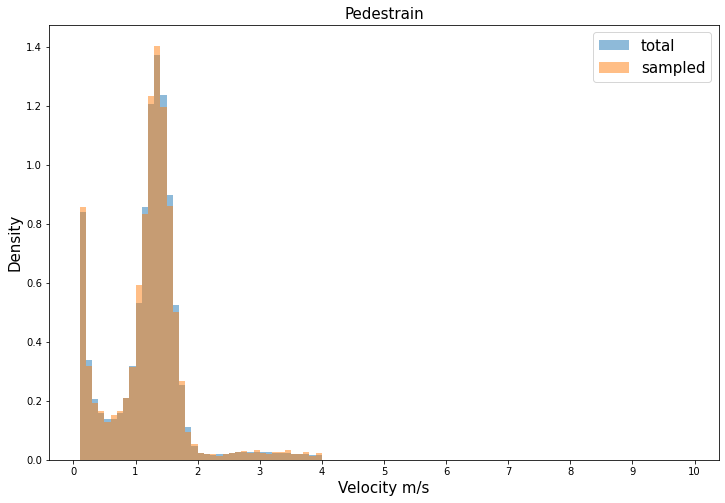

In [122]:
plt.figure(figsize=(12,8))
total_density,_,_ = plt.hist(np.concatenate([[0],pedestrian_interest]),bins=[0.1*x for x in range(1,100)],label = 'total',density=True, alpha = 0.5)
sample_density,_,_ = plt.hist(np.concatenate([[0],sampled_pedestrian_interest]),bins=[0.1*x for x in range(1,100)],label = 'sampled',density=True, alpha = 0.5)
plt.xticks(range(11))
plt.xlabel('Velocity m/s',fontsize = 15)
plt.ylabel('Density',fontsize = 15)
plt.title('Pedestrain',fontsize = 15)
plt.legend(fontsize=15)

In [113]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.006, 0.0079, 20)},
                    cv=30) # 30-fold cross-validation
grid.fit(sampled_pedestrian_interest[:, None])
print(grid.best_params_)
print(grid.best_estimator_)

{'bandwidth': 0.0074}
KernelDensity(bandwidth=0.0074)


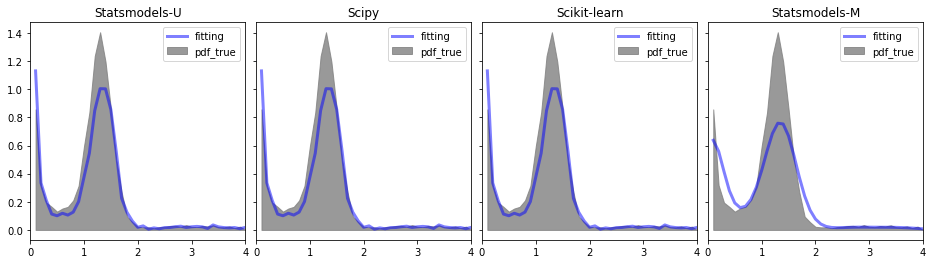

In [125]:
# The grid we'll use for plotting
x_grid = np.linspace(0.1, 4, 40)

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,figsize=(16, 4))
fig.subplots_adjust(wspace=0.05)
pdf_result = {}


for i, name in enumerate(kde_funcnames):
    pdf = kde_funcs[i](sampled_pedestrian_interest, x_grid, bandwidth=0.0074)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3,label='fitting')
    ax[i].fill_between(np.linspace(0.1, 4, 40), sample_density[:40], ec='gray', fc='gray', alpha=0.8, label='pdf_true')
    ax[i].legend(fontsize = 10)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(0, 4)
    
    pdf_result[name] = pdf

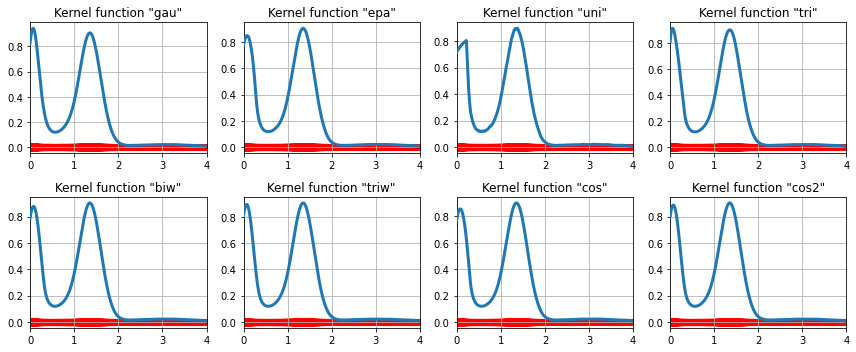

In [107]:
# test different kernels in statsmodels.univariate

from scipy import stats
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs
from statsmodels.nonparametric.kde import kernel_switch

kde = sm.nonparametric.KDEUnivariate(sampled_pedestrian_interest)

# Create a figure
fig = plt.figure(figsize=(12, 5))

# Enumerate every option for the kernel
for i, kernel in enumerate(kernel_switch.keys()):

    # Create a subplot, set the title
    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title('Kernel function "{}"'.format(kernel))

    # Fit the model (estimate densities)
    kde.fit(kernel=kernel, fft=False, gridsize=2**10)

    # Create the plot
    ax.plot(kde.support, kde.density, lw=3, label='KDE from samples', zorder=10)
    ax.scatter(sampled_pedestrian_interest, np.zeros_like(sampled_pedestrian_interest), marker='x', color='red')
    plt.grid(True, zorder=-5)
    ax.set_xlim([0, 4])

plt.tight_layout()

## Process vehicle velocity data

In [129]:
with open('vehicle_velocity_data.pkl', 'rb') as f:
    vehicle_velocity_data = pickle.load(f)

In [147]:
# select the velocity range of interest
vehicle_interest = vehicle_velocity_data[(vehicle_velocity_data<25)&(vehicle_velocity_data>1)]

In [184]:
# since the dimension of this data is too large, to reduce the computation complexity, random sampling is applied

N = 100000
index = sample(range(vehicle_interest.size),N)
sampled_vehicle_interest = vehicle_interest[index]

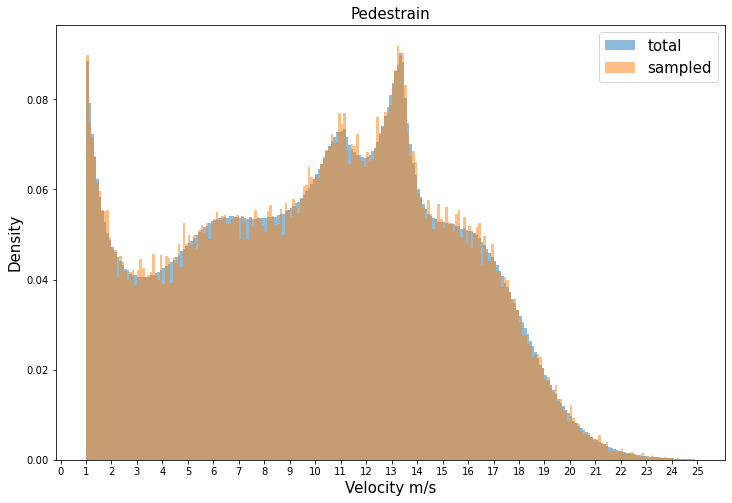

In [185]:
plt.figure(figsize=(12,8))
total_density,_,_ = plt.hist(vehicle_interest,bins=[0.1*x for x in range(10,250)],label = 'total',density=True, alpha = 0.5)
sample_density,_,_ = plt.hist(sampled_vehicle_interest,bins=[0.1*x for x in range(10,250)],label = 'sampled',density=True, alpha = 0.5)
plt.xticks(range(26))
plt.xlabel('Velocity m/s',fontsize = 15)
plt.ylabel('Density',fontsize = 15)
plt.title('Pedestrain',fontsize = 15)
plt.legend(fontsize=15)

In [183]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.05, 0.1, 10)},
                    cv=20) # 30-fold cross-validation
grid.fit(sampled_vehicle_interest[:, None])
print(grid.best_params_)
print(grid.best_estimator_)

{'bandwidth': 0.07777777777777778}
KernelDensity(bandwidth=0.07777777777777778)


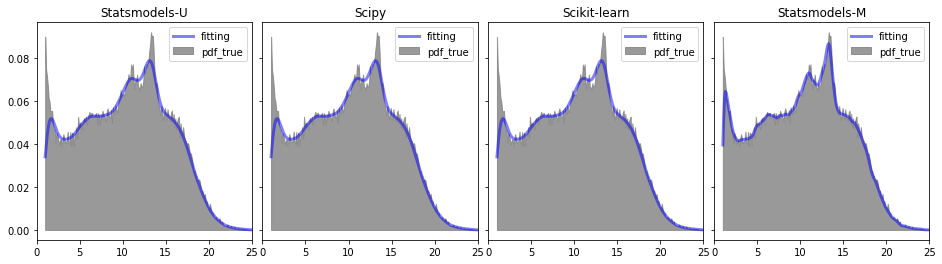

In [190]:
# The grid we'll use for plotting
x_grid = np.linspace(1, 25, 239)

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,figsize=(16, 4))
fig.subplots_adjust(wspace=0.05)
pdf_result_vehicle = {}


for i, name in enumerate(kde_funcnames):
    pdf = kde_funcs[i](sampled_vehicle_interest, x_grid, bandwidth=0.5)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3,label='fitting')
    ax[i].fill_between(x_grid, sample_density, ec='gray', fc='gray', alpha=0.8, label='pdf_true')
    ax[i].legend(fontsize = 10)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(0, 25)
    
    pdf_result_vehicle[name] = pdf

In [194]:
KDE_result = {'pedestrian':pdf_result, 'vehicle':pdf_result_vehicle}

In [195]:
with open('KDE_result.pkl', 'wb') as f:
        pickle.dump(KDE_result, f)